[OK] preprocess_shared loaded.
[INFO] Device: cpu
[INFO] Trial: S1-pr-TWEO-G-T2.xdf
[INFO] XDF path: R:\Research Projects\NASA_Full\NASA Data Extraction_CF\Input Data\xdf_RawData\S1-pr-TWEO-G-T2.xdf


Stream 4: Calculated effective sampling rate 88.9661 Hz is different from specified rate 50.0000 Hz.
Stream 12: Calculated effective sampling rate 199.0655 Hz is different from specified rate 100.0000 Hz.
Stream 23: Calculated effective sampling rate 7.7475 Hz is different from specified rate 1024.0000 Hz.
Stream 4: Calculated effective sampling rate 88.9661 Hz is different from specified rate 50.0000 Hz.
Stream 12: Calculated effective sampling rate 199.0655 Hz is different from specified rate 100.0000 Hz.
Stream 23: Calculated effective sampling rate 7.7475 Hz is different from specified rate 1024.0000 Hz.



[RAW GAP] COM raw: 1 gaps (dt > 5x median)
  gap: 8062.529 -> 8062.651  (dt=0.121s)

[RAW GAP] MoS raw (CSV): 6 gaps (dt > 5x median)
  gap: 0.964 -> 1.149  (dt=0.185s)
  gap: 2.015 -> 2.215  (dt=0.200s)
  gap: 2.881 -> 3.399  (dt=0.518s)
  gap: 4.133 -> 4.899  (dt=0.766s)
  gap: 5.699 -> 5.801  (dt=0.102s)
  gap: 6.851 -> 6.978  (dt=0.127s)


Stream 4: Calculated effective sampling rate 88.9661 Hz is different from specified rate 50.0000 Hz.
Stream 12: Calculated effective sampling rate 199.0655 Hz is different from specified rate 100.0000 Hz.
Stream 23: Calculated effective sampling rate 7.7475 Hz is different from specified rate 1024.0000 Hz.



[MISSING CHECK] On uniform grid BEFORE filling:
[OK] All features are finite after filling.


Stream 4: Calculated effective sampling rate 88.9661 Hz is different from specified rate 50.0000 Hz.
Stream 12: Calculated effective sampling rate 199.0655 Hz is different from specified rate 100.0000 Hz.
Stream 23: Calculated effective sampling rate 7.7475 Hz is different from specified rate 1024.0000 Hz.


[INFO] Missteps found for plotting: 3

[INFO] Model expects in_channels=15, out_horizons=10
[OK] Using checkpoint feature order (15 features).
[OK] Feature order verified against checkpoint (15 features).

[SAVED] trial_probs_filled.csv
[INFO] Rows: 419 | Cols: 11
[SAVED] trial_probs_with_missteps.png


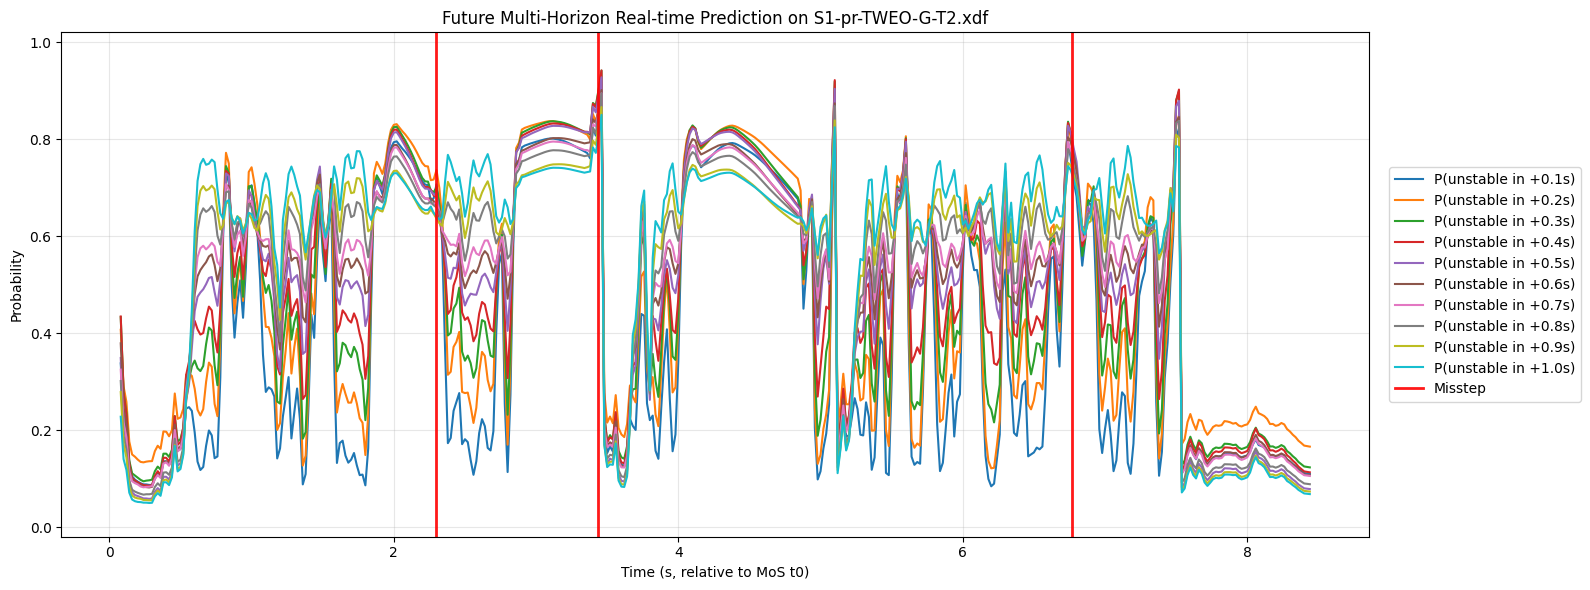

In [6]:
%run J_preprocess_shared_UPDATED.ipynb

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ========================= USER CONFIG =========================
TRIAL_XDF = r"S1-pr-TWEO-G-T2.xdf"

XDF_ROOT_CF = r"R:\Research Projects\NASA_Full\NASA Data Extraction_CF\Input Data\xdf_RawData"
XDF_ROOT_SD = r"R:\Research Projects\NASA_Full\NASA Data Extraction_SD\Input Data\xdf_RawData"
B_CSV_PATH  = r"R:\Research Projects\NASA_Full\Other side projects\859 Class project\MateoCode\all_b_values_all_xdf.csv"

# NEW: misstep Excel (same as NPZ builder)
MISSTEP_XLSX = r"R:\Research Projects\NASA_Full\Other side projects\859 Class project\MateoCode\video frames.xlsx"

CKPT_PATH = r"tcn_multihorizon_best.pt"
OUT_CSV   = r"trial_probs_filled.csv"
OUT_PNG   = r"trial_probs_with_missteps.png"

# Must match NPZ builder
EMG_STREAM_NAME = "EMG"
COM_STREAM_NAME = "CenterOfMass1"

KIN_STREAM_NAME = "LinearSegmentKinematicsDatagram1"
INCLUDE_KIN_ACC_FEATURES = True   # set True to append ACCmag_Pelvis/T8/Head
ALLOW_FEATURE_MISMATCH = False     # keep False for strict safety (old behavior)
TARGET_FS = 50.0

INPUT_WINDOW_SEC = 0.10
STRIDE_SEC = 1.0 / TARGET_FS

MAX_GAP_SEC = 1.0
PRINT_TOP_N_SEGMENTS = 50

cfg = PreprocConfig(
    xdf_root_cf=XDF_ROOT_CF,
    xdf_root_sd=XDF_ROOT_SD,
    emg_stream_name=EMG_STREAM_NAME,
    com_stream_name=COM_STREAM_NAME,
    kin_stream_name=KIN_STREAM_NAME,
    include_kin_acc_features=INCLUDE_KIN_ACC_FEATURES,
    kin_strict=False,
    target_fs=TARGET_FS,
    # IMPORTANT: to match your builder jitter band (affects only interval plotting if you use it)
    event_tol_pre_sec=0.05,
    event_tol_post_sec=0.10,
)

# ========================= Model (must match training) =========================
class SimpleTCN(nn.Module):
    def __init__(self, in_channels, out_horizons, hidden_channels=64, num_layers=4, kernel_size=3, dropout=0.1):
        super().__init__()
        layers = []
        c_in = in_channels
        for i in range(num_layers):
            dilation = 2 ** i
            padding = (kernel_size - 1) * dilation
            layers.append(
                nn.Sequential(
                    nn.Conv1d(c_in, hidden_channels, kernel_size, padding=padding, dilation=dilation),
                    nn.BatchNorm1d(hidden_channels),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                )
            )
            c_in = hidden_channels
        self.tcn = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_channels, out_horizons)

    def forward(self, x):
        feat = self.tcn(x)
        feat = self.global_pool(feat).squeeze(-1)
        return self.fc(feat)

def get_device():
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def load_checkpoint_and_model(ckpt_path: str, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    ckpt_feature_names = ckpt.get("feature_names", None)
    if ckpt_feature_names is not None:
        ckpt_feature_names = [str(x) for x in ckpt_feature_names]

    if not isinstance(ckpt, dict) or "state_dict" not in ckpt:
        raise ValueError("Checkpoint must be a dict with key 'state_dict'.")

    in_channels = int(ckpt.get("in_channels", 0))
    out_horizons = int(ckpt.get("out_horizons", 0))
    hidden_channels = int(ckpt.get("hidden_channels", 64))
    num_layers = int(ckpt.get("num_layers", 4))
    kernel_size = int(ckpt.get("kernel_size", 3))
    dropout = float(ckpt.get("dropout", 0.1))
    horizons_sec = ckpt.get("horizons_sec", None)

    model = SimpleTCN(
        in_channels=in_channels,
        out_horizons=out_horizons,
        hidden_channels=hidden_channels,
        num_layers=num_layers,
        kernel_size=kernel_size,
        dropout=dropout,
    ).to(device)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()

    return model, horizons_sec, in_channels, out_horizons, ckpt_feature_names

# ========================= Misstep time extraction for THIS trial =========================
def get_misstep_times_for_trial(trial_xdf: str, xdf_path: str, mos_ts0: float, cfg: PreprocConfig):
    """
    Returns:
      misstep_times_rel: list[float] misstep times (seconds) relative to MoS t0 (mos_ts0)
    Needs:
      - misstep frames from Excel
      - video stream to map frame -> video time
      - align to MoS timeline via offset like in builder
    """
    misstep_dict, _ = load_missteps_from_excel(MISSTEP_XLSX)
    missteps = misstep_dict.get(trial_xdf, [])
    if len(missteps) == 0:
        return []

    video_df = load_video_df(xdf_path, cfg)
    if video_df is None or video_df.empty:
        print("[WARN] Video stream not found; cannot map frames -> times.")
        return []

    intervals = map_frames_to_event_intervals(video_df, mos_ts0=mos_ts0, missteps=missteps, cfg=cfg)

    # Convert intervals to a single time per event: center of the band
    times_abs = [0.5 * (t_s + t_e) for (t_s, t_e, _typ) in intervals]
    times_rel = [float(t - mos_ts0) for t in times_abs]
    times_rel = sorted(times_rel)

    return times_rel

# ========================= MAIN =========================
def main():
    trial = normalize_trial_name(TRIAL_XDF)
    xdf_path = find_xdf_path(trial, cfg)
    if not xdf_path:
        raise FileNotFoundError(f"Could not find {trial} in CF/SD roots.")

    device = get_device()
    print("[INFO] Device:", device)
    print("[INFO] Trial:", trial)
    print("[INFO] XDF path:", xdf_path)

    # Load streams
    emg_df = load_stream_df(xdf_path, cfg.emg_stream_name, "EMG_ch")
    com_df = load_stream_df(xdf_path, cfg.com_stream_name, "COM_ch")
    if emg_df is None:
        raise RuntimeError(f"Missing EMG stream '{cfg.emg_stream_name}' in XDF.")
    if com_df is None:
        raise RuntimeError(f"Missing COM stream '{cfg.com_stream_name}' in XDF.")

    raw_gap_report(emg_df, "EMG raw", top_n=PRINT_TOP_N_SEGMENTS)
    raw_gap_report(com_df, "COM raw", top_n=PRINT_TOP_N_SEGMENTS)

    # EMG preprocessing (same as builder)
    emg_df = clean_emg_envelope(emg_df, cfg)

    # Load MoS
    mos_df = load_mos_df_for_trial(B_CSV_PATH, trial, cfg)
    if mos_df is None or mos_df.empty:
        raise RuntimeError(f"No MoS rows found in CSV for file_name = {trial}")
    raw_gap_report(mos_df, "MoS raw (CSV)", top_n=PRINT_TOP_N_SEGMENTS)

    # Uniform features
    kin_df = None
    if getattr(cfg, "include_kin_acc_features", False):
        kin_df = load_kin_df(xdf_path, cfg)

    t_uniform_abs, feat_df, feature_names = build_uniform_features(mos_df, emg_df, com_df, cfg, kin_df=kin_df)
    if t_uniform_abs is None:
        raise RuntimeError("Trial too short (or invalid) after MoS timeline checks.")

    # ---- FIX #1: define t_uniform for later windowing ----
    t_uniform = t_uniform_abs

    # Force numeric
    for c in feat_df.columns:
        feat_df[c] = pd.to_numeric(feat_df[c], errors="coerce")

    # Fill gaps
    feat_df_filled = fill_short_gaps_per_column(
        feat_df, time_col="timestamp", max_gap_sec=MAX_GAP_SEC, fs=cfg.target_fs, print_top_n=PRINT_TOP_N_SEGMENTS
    )

    # Load misstep times (relative to MoS t0)
    mos_ts0 = float(feat_df_filled["timestamp"].values[0])
    misstep_times_rel = get_misstep_times_for_trial(trial, xdf_path, mos_ts0=mos_ts0, cfg=cfg)
    print(f"[INFO] Missteps found for plotting: {len(misstep_times_rel)}")

    # Load model
    model, horizons_sec, in_channels, out_horizons, ckpt_feature_names = load_checkpoint_and_model(CKPT_PATH, device)
    print(f"\n[INFO] Model expects in_channels={in_channels}, out_horizons={out_horizons}")

    if horizons_sec is None:
        horizons = [float(i) for i in range(out_horizons)]
    else:
        horizons = [float(x) for x in horizons_sec]
        if len(horizons) != out_horizons:
            print("[WARN] horizons_sec length != out_horizons; using index-based horizons.")
            horizons = [float(i) for i in range(out_horizons)]

    # Build X_seq (drop timestamp)
    # Build X_seq using checkpoint-defined feature order (single source of truth)
    cols_full = [c for c in feat_df_filled.columns if c != "timestamp"]
    
    # Enforce EXACT subset + order used during training
    if ckpt_feature_names is None:
        raise RuntimeError(
            "Checkpoint does not contain feature_names. "
            "Cannot enforce feature subset/order. Re-train once with feature_names saved."
        )
    
    # (Optional sanity: ensure all required features exist in this trial)
    missing = [c for c in ckpt_feature_names if c not in cols_full]
    if missing:
        raise RuntimeError(f"Missing required features in inference data: {missing}")
    
    cols_for_model = ckpt_feature_names
    X_seq = feat_df_filled[cols_for_model].values.astype(np.float32)
    
    print(f"[OK] Using checkpoint feature order ({len(cols_for_model)} features).")


    # ---- NEW: strict feature order check (training vs inference) ----
    if ckpt_feature_names is not None:
        if cols_for_model != ckpt_feature_names:
            # Find first mismatch to make debugging fast
            i_bad = None
            for i, (a, b) in enumerate(zip(cols_for_model, ckpt_feature_names)):
                if a != b:
                    i_bad = i
                    break
            raise RuntimeError(
                "FEATURE ORDER MISMATCH between inference build and checkpoint!\n"
                f"Built (len={len(cols_for_model)}): {cols_for_model}\n"
                f"CKPT  (len={len(ckpt_feature_names)}): {ckpt_feature_names}\n"
                + (f"First mismatch at index {i_bad}: built='{cols_for_model[i_bad]}' vs ckpt='{ckpt_feature_names[i_bad]}'\n"
                   if i_bad is not None else
                   "Mismatch appears to be length-only or beyond shared prefix.\n")
            )
        print(f"[OK] Feature order verified against checkpoint ({len(ckpt_feature_names)} features).")
    else:
        print("[WARN] Checkpoint has no 'feature_names' stored; cannot verify order. Re-train once with feature_names saved.")


    if X_seq.shape[1] != in_channels:
        print("\n[ERROR] Feature count mismatch.")
        print("  Built feature columns:", cols_for_model)
        print("  Built C =", X_seq.shape[1], "but model expects", in_channels)

        if not ALLOW_FEATURE_MISMATCH:
            raise RuntimeError("Feature order/count mismatch. To proceed anyway, set ALLOW_FEATURE_MISMATCH=True.")
        else:
            if X_seq.shape[1] > in_channels:
                print("[WARN] Truncating extra feature columns to match model input size.")
                cols_for_model = cols_for_model[:in_channels]
                X_seq = X_seq[:, :in_channels]
            else:
                print("[WARN] Padding missing feature columns with zeros to match model input size.")
                pad = in_channels - X_seq.shape[1]
                X_seq = np.concatenate([X_seq, np.zeros((X_seq.shape[0], pad), dtype=X_seq.dtype)], axis=1)

    # Windowing (build sliding windows on the uniform time grid)
    n = len(t_uniform)
    input_len = max(1, int(round(INPUT_WINDOW_SEC * TARGET_FS)))
    stride = max(1, int(round(STRIDE_SEC * TARGET_FS)))

    if n < input_len:
        raise RuntimeError(
            f"Not enough samples for windowing: n={n} < input_len={input_len}. "
            f"Check TARGET_FS / INPUT_WINDOW_SEC / MoS coverage for this trial."
        )

    # ---- FIX #2: correct np.arange line ----
    starts = np.arange(0, n - input_len + 1, stride, dtype=int)
    lasts = starts + input_len - 1

    probs_all = []
    times_rel = []

    BATCH = 512
    with torch.no_grad():
        for i0 in range(0, len(starts), BATCH):
            i1 = min(i0 + BATCH, len(starts))
            s_batch = starts[i0:i1]
            l_batch = lasts[i0:i1]

            Xw = np.stack([X_seq[s:s+input_len] for s in s_batch], axis=0)  # (B,L,C)
            Xw = np.transpose(Xw, (0, 2, 1))  # (B,C,L)
            xb = torch.from_numpy(Xw).to(device, dtype=torch.float32)

            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().numpy()  # (B,H)
            probs_all.append(probs)

            t_end_abs = feat_df_filled["timestamp"].values[l_batch].astype(float)
            t_rel = t_end_abs - mos_ts0
            times_rel.append(t_rel)

    probs_all = np.concatenate(probs_all, axis=0)
    times_rel = np.concatenate(times_rel, axis=0)

    # Output dataframe
    out = pd.DataFrame({"time_s": times_rel.astype(float)})
    for h_idx, h in enumerate(horizons):
        out[f"prob_+{h:.1f}s"] = probs_all[:, h_idx].astype(float)

    out = out.sort_values("time_s").drop_duplicates(subset=["time_s"]).reset_index(drop=True)
    out.to_csv(OUT_CSV, index=False)
    print(f"\n[SAVED] {OUT_CSV}")
    print(f"[INFO] Rows: {len(out)} | Cols: {len(out.columns)}")

    # -------------------------
    # Plot (like your screenshot) + vertical misstep lines
    # -------------------------
    fig, ax = plt.subplots(figsize=(16, 6))

    for h_idx, h in enumerate(horizons):
        ax.plot(out["time_s"].values, out[f"prob_+{h:.1f}s"].values, linewidth=1.5, label=f"P(unstable in +{h:.1f}s)")

    # Misstep vertical lines
    if len(misstep_times_rel) > 0:
        for i, t in enumerate(misstep_times_rel):
            if i == 0:
                ax.axvline(t, color="red", linewidth=2.0, alpha=0.9, label="Misstep")
            else:
                ax.axvline(t, color="red", linewidth=2.0, alpha=0.9)

    ax.set_title(f"Future Multi-Horizon Real-time Prediction on {trial}")
    ax.set_xlabel("Time (s, relative to MoS t0)")
    ax.set_ylabel("Probability")

    ax.set_ylim(-0.02, 1.02)
    ax.grid(True, alpha=0.3)

    ax.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), frameon=True)
    plt.tight_layout()

    plt.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
    print(f"[SAVED] {OUT_PNG}")

    plt.show()

main()


In [2]:
# code that test feature mismatch exists

import numpy as np
import torch

# NPZ
d = np.load("tcn_dataset_b_emg_com_future_multihorizon_missteps.npz", allow_pickle=True)
npz_feats = [str(x) for x in d["feature_names"]]
print("NPZ feature_names:", npz_feats)

# CKPT
ckpt = torch.load("tcn_multihorizon_best.pt", map_location="cpu")
ckpt_feats = [str(x) for x in ckpt["feature_names"]]
print("CKPT feature_names:", ckpt_feats)

print("MATCH:", npz_feats == ckpt_feats)


NPZ feature_names: ['b_cm', 'b_m', 'EMG_ch1_env', 'EMG_ch2_env', 'EMG_ch3_env', 'EMG_ch4_env', 'EMG_ch5_env', 'EMG_ch6_env', 'EMG_ch7_env', 'EMG_ch8_env', 'ACCmag_Pelvis', 'ACCmag_T8', 'ACCmag_Head', 'COM_ch1', 'COM_ch2', 'COM_ch3']
CKPT feature_names: ['b_cm', 'b_m', 'EMG_ch1_env', 'EMG_ch2_env', 'EMG_ch3_env', 'EMG_ch4_env', 'EMG_ch5_env', 'EMG_ch6_env', 'EMG_ch7_env', 'EMG_ch8_env', 'ACCmag_Pelvis', 'ACCmag_T8', 'ACCmag_Head', 'COM_ch1', 'COM_ch2', 'COM_ch3']
MATCH: True
